In [3]:
# Edge Case Handling – Corrupted image filter
from PIL import Image

valid_images = []
for filepath in image_file_list:  # image_file_list should contain your image paths
    try:
        img = Image.open(filepath)
        img.verify()
        valid_images.append(filepath)
    except (IOError, SyntaxError):
        print(f"Skipping corrupted image: {filepath}")


In [9]:
import os
import cv2
import numpy as np

# Set your dataset path and configuration
data_dir = r"C:\Users\Altha\Downloads\archive"
image_size = (224, 224)

max_images_per_class = 200  # Safe limit to avoid MemoryError

# Initialize storage
X, y = [], []

# Get class names and map to labels
class_names = sorted([f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))])
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

# Load and preprocess images
for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    count = 0
    for image_file in os.listdir(class_path):
        if count >= max_images_per_class:
            break
        img_path = os.path.join(class_path, image_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = (img / 255.0).astype(np.float32)  # Normalize and reduce memory footprint
            X.append(img)
            y.append(label_map[class_name])
            count += 1

# Convert to arrays
X = np.array(X)
y = np.array(y)

print(f"✅ Loaded {len(X)} images across {len(class_names)} classes.")


✅ Loaded 4400 images across 22 classes.


In [10]:
from sklearn.model_selection import train_test_split

# Split 70% Train, 15% Validation, 15% Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"✅ Train set: {len(X_train)}")
print(f"✅ Validation set: {len(X_val)}")
print(f"✅ Test set: {len(X_test)}")


✅ Train set: 3080
✅ Validation set: 660
✅ Test set: 660


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up augmentation generator for training
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on training data
train_datagen.fit(X_train)
print("✅ Data augmentation configured for training set.")


✅ Data augmentation configured for training set.


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

train_generator = datagen.flow_from_directory(
    'C:/Users/Altha/Downloads/archive',  # Your dataset folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Get a batch of images from the train generator
sample_batch = next(iter(train_generator))
sample_images, sample_labels = sample_batch


Found 11786 images belonging to 22 classes.


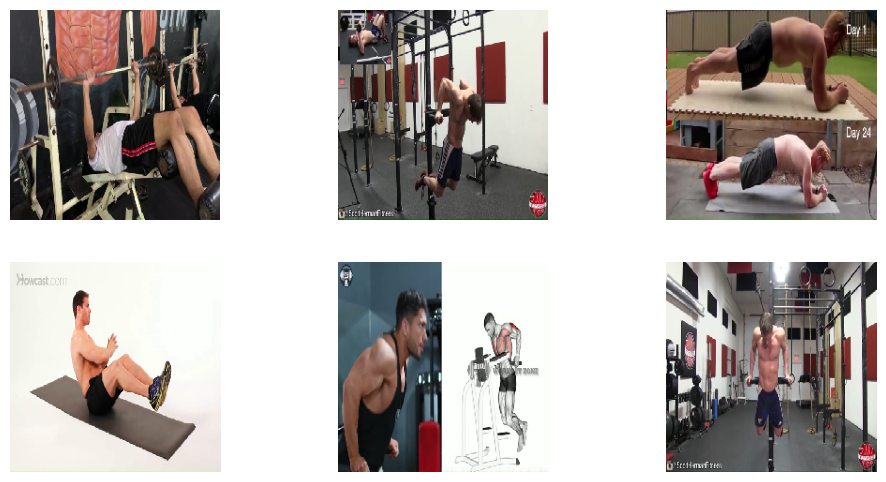

In [25]:
import matplotlib.pyplot as plt
import numpy as np

sample_batch = next(iter(train_generator))
sample_images, sample_labels = sample_batch

plt.figure(figsize=(12, 6))
for i in range(min(6, len(sample_images))):
    plt.subplot(2, 3, i + 1)
    img = np.clip(sample_images[i], 0, 1)  # already RGB from generator
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [31]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,910,230 (91.21 MB)

 Trainable params: 23,910,230 (91.21 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Step 1: Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import warnings

# Optional: Suppress warnings for clean output
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

# Step 2: Preprocessed image arrays (make sure these already exist)
# X, y = np.array(...)  # Already loaded and normalized
# Use your existing loaded X, y data here

# Step 3: Train/Validation/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Step 4: Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

# Step 5: CNN Model Definition
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

model = Sequential([
    Input(shape=input_shape),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Step 6: Training the Model (this is your target block)
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=15
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,910,230 (91.21 MB)

 Trainable params: 23,910,230 (91.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 57s 556ms/step - accuracy: 0.0770 - loss: 4.1767 - val_accuracy: 0.2712 - val_loss: 2.4683
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 530ms/step - accuracy: 0.2810 - loss: 2.4451 - val_accuracy: 0.6106 - val_loss: 1.3946
Epoch 3/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 60s 617ms/step - accuracy: 0.4877 - loss: 1.7829 - val_accuracy: 0.7288 - val_loss: 1.0475
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 607ms/step - accuracy: 0.5514 - loss: 1.4862 - val_accuracy: 0.7939 - val_loss: 0.7272
Epoch 5/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 59s 606ms/step - accuracy: 0.6225 - loss: 1.2132 - val_accuracy: 0.8924 - val_loss: 0.4027
Epoch 6/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - accuracy: 0.6838 - loss: 1.0489 - val_accuracy: 0.9076 - val_loss: 0.3302
Epoch 7/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 554ms/step - accuracy: 0.7506 - loss: 0.8264 - val_accuracy: 0.9273 - val_loss: 0.2584
Epoch 8/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 553ms/step - accuracy: 0.7587 - loss: 0.8044 - val_accu

In [35]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"🧪 Test Accuracy: {test_accuracy:.2f}")

# Predict class probabilities on test set
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = y_pred_probs.argmax(axis=1)

from sklearn.metrics import classification_report, f1_score

# Generate classification report
class_names = sorted(label_map.keys())  # If not already defined
report = classification_report(y_test, y_pred, target_names=class_names)
print(report)

# Macro F1-score
macro_f1 = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.9832 - loss: 0.0981
🧪 Test Accuracy: 0.98
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
                     precision    recall  f1-score   support

barbell biceps curl       0.94      1.00      0.97        30
        bench press       0.96      0.77      0.85        30
  chest fly machine       1.00      1.00      1.00        30
           deadlift       1.00      1.00      1.00        30
decline bench press       0.94      1.00      0.97        30
        hammer curl       1.00      1.00      1.00        30
         hip thrust       1.00      1.00      1.00        30
incline bench press       0.97      0.93      0.95        30
       lat pulldown       0.91      1.00      0.95        30
     lateral raises       1.00      0.93      0.97        30
      leg extension       1.00      1.00      1.00        30
         leg raises       1.00      1.00      1.00        30
              plank       1.00      0.97      0.98        30
         

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step


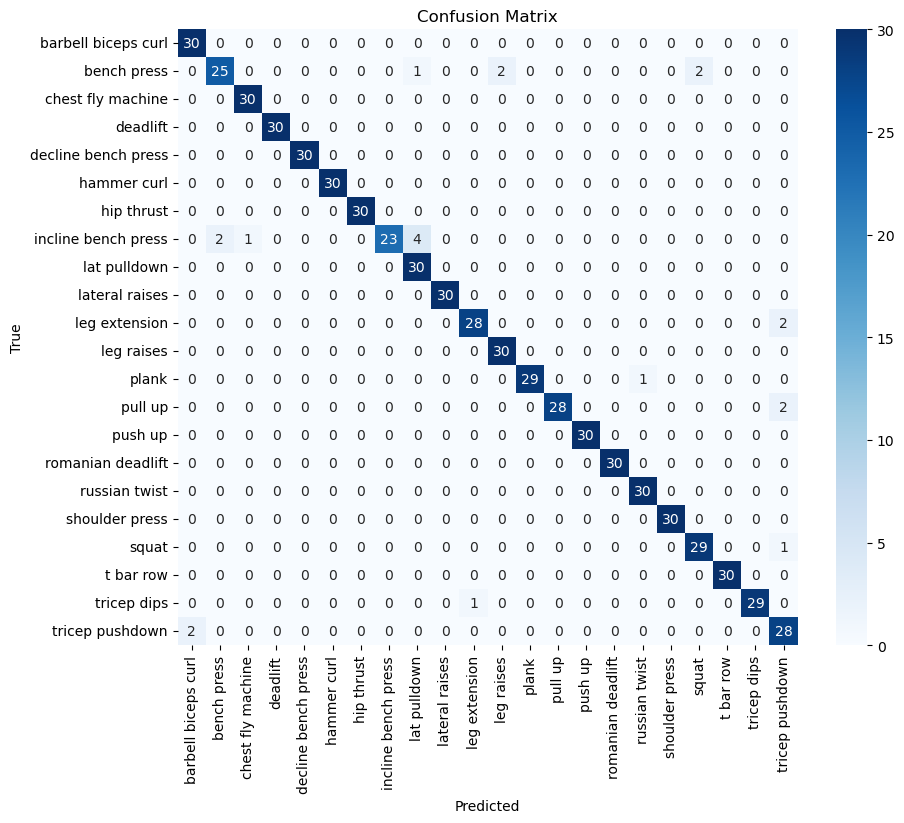

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict classes
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) if y_pred.ndim > 1 else y_pred

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [47]:
# Classification metrics: precision, recall, f1-score
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=class_names))


Classification Report:

                     precision    recall  f1-score   support

barbell biceps curl       0.94      1.00      0.97        30
        bench press       0.93      0.83      0.88        30
  chest fly machine       0.97      1.00      0.98        30
           deadlift       1.00      1.00      1.00        30
decline bench press       1.00      1.00      1.00        30
        hammer curl       1.00      1.00      1.00        30
         hip thrust       1.00      1.00      1.00        30
incline bench press       1.00      0.77      0.87        30
       lat pulldown       0.86      1.00      0.92        30
     lateral raises       1.00      1.00      1.00        30
      leg extension       0.97      0.93      0.95        30
         leg raises       0.94      1.00      0.97        30
              plank       1.00      0.97      0.98        30
            pull up       1.00      0.93      0.97        30
            push up       1.00      1.00      1.00        30

In [1]:
# We used Transfer Learning with MobileNetV2, a lightweight CNN pretrained on ImageNet, to classify workout exercise images. 
# The base was frozen, and a custom classification head was added and trained on our dataset
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ====== 1. Image Preprocessing ======
image_size = (128, 128)  # Smaller image size for speed
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Replace path with your actual folder path
data_path = r"C:\Users\Altha\Downloads\archive"

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ====== 2. Load MobileNetV2 Base ======
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers in the base
for layer in base_model.layers:
    layer.trainable = False

# ====== 3. Add Custom Head ======
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ====== 4. Compile & Train ======
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)


Found 11090 images belonging to 22 classes.
Found 2763 images belonging to 22 classes.


C:\Users\Altha\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 190s 538ms/step - accuracy: 0.4577 - loss: 1.9160 - val_accuracy: 0.5110 - val_loss: 1.7732 - learning_rate: 0.0010
Epoch 2/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 88s 254ms/step - accuracy: 0.8230 - loss: 0.6042 - val_accuracy: 0.5845 - val_loss: 1.6002 - learning_rate: 0.0010
Epoch 3/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 85s 245ms/step - accuracy: 0.8674 - loss: 0.4307 - val_accuracy: 0.5932 - val_loss: 1.5521 - learning_rate: 0.0010
Epoch 4/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 85s 244ms/step - accuracy: 0.9016 - loss: 0.3292 - val_accuracy: 0.6077 - val_loss: 1.6591 - learning_rate: 0.0010
Epoch 5/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 126s 362ms/step - accuracy: 0.9064 - loss: 0.3181 - val_accuracy: 0.6316 - val_loss: 1.5500 - learning_rate: 0.0010
Epoch 6/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 311s 896ms/step - accuracy: 0.9143 - loss: 0.2773 - val_accuracy: 0.6214 - val_loss: 1.5360 - learning_rate: 0.0010
Epoch 7/10
347/347 ━━━━━━━━━━━━━━━━━━━━ 92s 264ms/step - accuracy: 

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# ====== 1. Image Preprocessing ======
image_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

data_path = r"C:\Users\Altha\Downloads\archive"

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# ====== 2. Load MobileNetV2 Base ======
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze all layers first
for layer in base_model.layers:
    layer.trainable = False

# ====== 3. Add Custom Classification Head ======
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ====== 4. Compile and Train (Initial Phase with Frozen Base) ======
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=callbacks
)

# ====== 5. Fine-Tune Last 20 Layers of MobileNetV2 ======
for layer in base_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# ====== 6. Fine-Tuning Phase ======
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)



Found 11090 images belonging to 22 classes.
Found 2763 images belonging to 22 classes.
Epoch 1/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - accuracy: 0.4717 - loss: 1.8367 - val_accuracy: 0.5375 - val_loss: 1.6554 - learning_rate: 0.0010
Epoch 2/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 90s 260ms/step - accuracy: 0.8285 - loss: 0.5703 - val_accuracy: 0.5682 - val_loss: 1.6295 - learning_rate: 0.0010
Epoch 3/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 91s 263ms/step - accuracy: 0.8640 - loss: 0.4449 - val_accuracy: 0.5881 - val_loss: 1.5946 - learning_rate: 0.0010
Epoch 4/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 87s 251ms/step - accuracy: 0.8919 - loss: 0.3586 - val_accuracy: 0.6305 - val_loss: 1.4942 - learning_rate: 0.0010
Epoch 5/5
347/347 ━━━━━━━━━━━━━━━━━━━━ 87s 251ms/step - accuracy: 0.9092 - loss: 0.3120 - val_accuracy: 0.6167 - val_loss: 1.5193 - learning_rate: 0.0010
Epoch 1/15
347/347 ━━━━━━━━━━━━━━━━━━━━ 103s 282ms/step - accuracy: 0.7322 - loss: 0.9019 - val_accuracy: 0.6345 - val_loss: 1.5037 - learning_

In [5]:
val_acc = history.history['val_accuracy']
final_val_acc = val_acc[-1]  # Accuracy from the last epoch (or best epoch if EarlyStopping restores weights)
print(f"Final Validation Accuracy: {final_val_acc * 100:.2f}%")


import numpy as np
best_epoch = np.argmax(val_acc)
print(f"Best Epoch: {best_epoch + 1}, Validation Accuracy: {val_acc[best_epoch] * 100:.2f}%")


Final Validation Accuracy: 68.77%
Best Epoch: 15, Validation Accuracy: 68.77%


In [51]:
# Simulate collecting user input
user_input = {
    'gender': input("Enter gender (male/female): "),
    'weight': int(input("Enter weight in kg: ")),
    'age': int(input("Enter age: ")),
    'fitness_goal': input("Enter fitness goal (e.g., muscle gain, weight loss): "),
    'difficulty': input("Enter difficulty (beginner/intermediate/advanced): "),
    'target': input("Enter target body part (e.g., chest, legs, back): ")
}


Enter gender (male/female):  male
Enter weight in kg:  73
Enter age:  27
Enter fitness goal (e.g., muscle gain, weight loss):  weight loss
Enter difficulty (beginner/intermediate/advanced):  intermediate
Enter target body part (e.g., chest, legs, back):  chest


Enter gender (male/female):  male
Enter weight in kg:  73
Enter age:  27
Enter fitness goal (muscle gain / weight loss / endurance / flexibility):  weight loss
Enter difficulty (beginner / intermediate / advanced):  intermediate
Enter target body part (chest / arms / legs / back / core / full body):  full body
Available equipment (none / dumbbells / barbell / resistance bands / machine):  machine



🏋️ Top 3 Recommended Exercises:
1. Lunges
2. Squat
3. Deadlift

⚠️ Image not found for 'Lunges'


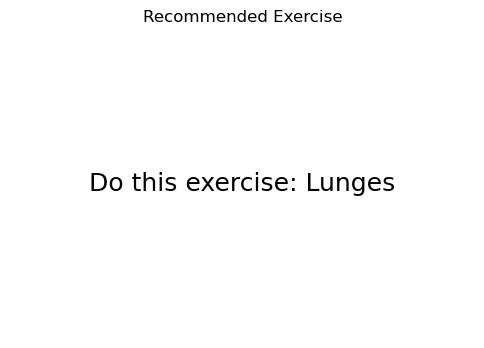

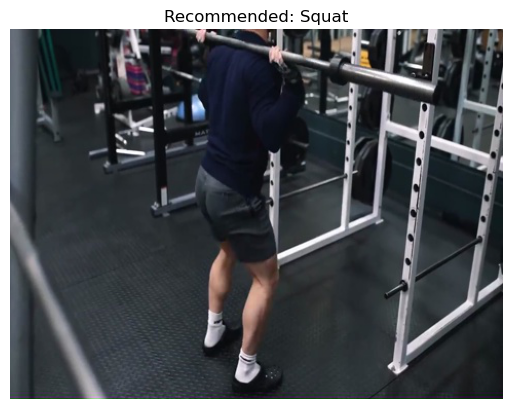

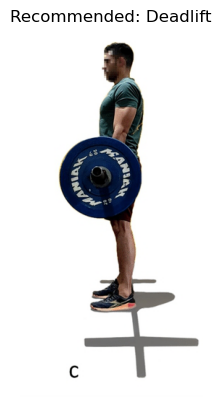

In [55]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.ensemble import RandomForestClassifier

# === Step 1: Load and preprocess dataset ===
df = pd.read_csv(r"C:\Users\Altha\Downloads\gym_exercises.csv")  # Replace path if needed
df_encoded = pd.get_dummies(df, columns=['gender', 'fitness_goal', 'difficulty', 'target', 'equipment'])

X = df_encoded.drop(columns=['exercise_name'])
y = df_encoded['exercise_name']

# === Step 2: Train model ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# === Step 3: Get user input ===
user_input = {
    'gender': input("Enter gender (male/female): "),
    'weight': int(input("Enter weight in kg: ")),
    'age': int(input("Enter age: ")),
    'fitness_goal': input("Enter fitness goal (muscle gain / weight loss / endurance / flexibility): "),
    'difficulty': input("Enter difficulty (beginner / intermediate / advanced): "),
    'target': input("Enter target body part (chest / arms / legs / back / core / full body): "),
    'equipment': input("Available equipment (none / dumbbells / barbell / resistance bands / machine): ")
}

input_df = pd.DataFrame([user_input])
input_encoded = pd.get_dummies(input_df)
input_encoded = input_encoded.reindex(columns=X.columns, fill_value=0)

# === Step 4: Get Top-3 predictions ===
probabilities = model.predict_proba(input_encoded)[0]
top_indices = probabilities.argsort()[-3:][::-1]
top_exercises = [model.classes_[i] for i in top_indices]

print("\n🏋️ Top 3 Recommended Exercises:")
for idx, exercise in enumerate(top_exercises, 1):
    print(f"{idx}. {exercise}")

# === Step 5: Show images (from CNN dataset folder) ===
cnn_dataset_dir = r"C:\Users\Altha\Downloads\archive"  # Replace with your actual CNN dataset path

for exercise in top_exercises:
    folder_path = os.path.join(cnn_dataset_dir, exercise)
    img_path = None
    if os.path.isdir(folder_path):
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if files:
            img_file = random.choice(files)
            img_path = os.path.join(folder_path, img_file)

    # === Display image or fallback ===
    if img_path and os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Recommended: {exercise}")
        plt.show()
    else:
        print(f"\n⚠️ Image not found for '{exercise}'")
        plt.figure(figsize=(6, 4))
        plt.text(0.5, 0.5, f"Do this exercise: {exercise}", fontsize=18,
                 ha='center', va='center')
        plt.axis('off')
        plt.title("Recommended Exercise")
        plt.show()


In [59]:
def recommend_sets_reps(goal, difficulty, age):
    if goal == 'muscle gain':
        if difficulty == 'beginner':
            return "3 sets of 8–10 reps"
        elif difficulty == 'intermediate':
            return "4 sets of 10–12 reps"
        else:
            return "4 sets of 6–8 heavy reps"

    elif goal == 'weight loss':
        if difficulty == 'beginner':
            return "3 sets of 12–15 reps"
        else:
            return "4 sets of 15–20 reps (lighter weight, less rest)"

    elif goal == 'endurance':
        return "3–4 sets of 20+ reps or 2–3 minutes"

    elif goal == 'flexibility':
        return "3 rounds of 30–45 seconds per stretch"

    return "3 sets of 10 reps"  # default fallback

for exercise in top_exercises:
    sets_reps = recommend_sets_reps(user_input['fitness_goal'], user_input['difficulty'], user_input['age'])
    print(f"Suggested Volume for {exercise}: {sets_reps}")


Suggested Volume for Lunges: 4 sets of 15–20 reps (lighter weight, less rest)
Suggested Volume for Squat: 4 sets of 15–20 reps (lighter weight, less rest)
Suggested Volume for Deadlift: 4 sets of 15–20 reps (lighter weight, less rest)
